In [63]:
#imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (StandardScaler, Binarizer, OrdinalEncoder, OneHotEncoder)
from sklearn.metrics import (confusion_matrix, f1_score, accuracy_score, roc_auc_score, roc_curve)
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import folium

In [2]:
#reading in raw data
df = pd.read_csv('vehicles.csv')
df.head(10)

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN
5,7222379453,https://hudsonvalley.craigslist.org/cto/d/west...,hudson valley,https://hudsonvalley.craigslist.org,1600,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ny,NaN,NaN,NaN
6,7221952215,https://hudsonvalley.craigslist.org/cto/d/west...,hudson valley,https://hudsonvalley.craigslist.org,1000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ny,NaN,NaN,NaN
7,7220195662,https://hudsonvalley.craigslist.org/cto/d/poug...,hudson valley,https://hudsonvalley.craigslist.org,15995,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ny,NaN,NaN,NaN
8,7209064557,https://medford.craigslist.org/cto/d/grants-pa...,medford-ashland,https://medford.craigslist.org,5000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,or,NaN,NaN,NaN
9,7219485069,https://erie.craigslist.org/cto/d/erie-2012-su...,erie,https://erie.craigslist.org,3000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,pa,NaN,NaN,NaN


In [3]:
### Printing summary of raw data
print(df.shape)
df.columns

(426880, 26)


Index(['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer',
       'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status',
       'transmission', 'VIN', 'drive', 'size', 'type', 'paint_color',
       'image_url', 'description', 'county', 'state', 'lat', 'long',
       'posting_date'],
      dtype='object')

In [5]:
df.describe()

,id,price,year,odometer,county,lat,long
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05,0.0,420331.000000,420331.000000
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04,NaN,38.493940,-94.748599
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05,NaN,5.841533,18.365462
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00,NaN,-84.122245,-159.827728
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04,NaN,34.601900,-111.939847
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04,NaN,39.150100,-88.432600
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05,NaN,42.398900,-80.832039
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07,NaN,82.390818,173.885502


In [37]:
# Number of non-null values in each column
missing_values = (df.isna().sum()/df.shape[0]).sort_values(ascending=False)
print(missing_values)

county          1.000000
size            0.717675
cylinders       0.416225
condition       0.407852
VIN             0.377254
drive           0.305863
paint_color     0.305011
type            0.217527
manufacturer    0.041337
title_status    0.019308
lat             0.015342
long            0.015342
model           0.012362
odometer        0.010307
fuel            0.007058
transmission    0.005988
year            0.002823
description     0.000164
image_url       0.000159
posting_date    0.000159
url             0.000000
price           0.000000
state           0.000000
region_url      0.000000
region          0.000000
id              0.000000
dtype: float64


In [21]:
np.count_nonzero(df[['price','VIN']].value_counts().duplicated())

122079

In [29]:

def count_duplicates(df, col_names):
    # Find duplicated values in the specified columns
    duplicated_values = df[df.duplicated(subset=col_names, keep=False)]

    # Count the number of duplicated values
    num_duplicates = len(duplicated_values)

    return num_duplicates

col_names = ['posting_date', 'VIN', 'price']
num_duplicates = count_duplicates(df, col_names)
num_duplicates

2196

In [31]:
col_names = ['VIN', 'posting_date']
num_duplicates = count_duplicates(df, col_names)
num_duplicates

9045

In [9]:
np.count_nonzero(df['VIN'].duplicated())

308615

<Axes: >

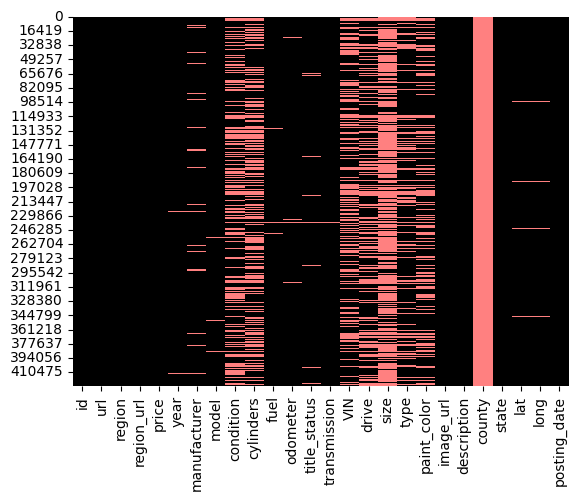

In [62]:
from matplotlib.colors import LinearSegmentedColormap

# Define the custom color map
custom_cmap = LinearSegmentedColormap.from_list(
    'custom', [(0, 0, 0), (1, 1, 1), (1, 0.5, 0.5)])

# Generate the missing values matrix
msk = df.isna()

# Generate the heatmap with the custom color map
sns.heatmap(msk, cmap=custom_cmap, cbar=False)

In [61]:
def get_missing_correlation(df):
    """
    Get the correlation matrix of missing values in a DataFrame.

    Parameters:
    -----------
    df: pandas DataFrame
        The DataFrame to check for missing value correlation.

    Returns:
    --------
    Tuple
        A tuple containing a boolean indicating if there is high correlation, 
        the mean correlation, the max correlation, and the column pairs with the 
        highest correlation.
    """
    # Create a missing values matrix
    msk = df.isna()

    # Calculate the correlation matrix of the missing values matrix
    corr_matrix = np.abs(msk.corr())

    # Replace NaN values with 0
    corr_matrix = np.nan_to_num(corr_matrix)
    
    # Set diagonal to 0
    np.fill_diagonal(corr_matrix, 0)

    # Calculate the mean and max correlation across all pairs of features
    mean_corr = np.mean(corr_matrix)
    max_corr = np.max(np.nan_to_num(corr_matrix))

    # Find the column pairs with the highest correlation
    max_corr_idxs = np.argwhere((0.5 <= corr_matrix) & 
                                (corr_matrix <= max_corr))
    max_corr_pairs = [(df.columns[i], df.columns[j]) for i, j in zip(*max_corr_idxs.T)]

    # Return True if the mean correlation is greater than 0.5, False otherwise
    if mean_corr > 0.5:
        return True, mean_corr, max_corr, max_corr_pairs
    else:
        return False, mean_corr, max_corr, max_corr_pairs


    
    
    
get_missing_correlation(df)


(False,
 0.05491979425755076,
 1.0,
 [('image_url', 'description'),
  ('image_url', 'posting_date'),
  ('description', 'image_url'),
  ('description', 'posting_date'),
  ('lat', 'long'),
  ('long', 'lat'),
  ('posting_date', 'image_url'),
  ('posting_date', 'description')])

In [84]:
# create a dictionary to map state abbreviations to full names
state_dict = {
    'AL': 'Alabama',
    'AK': 'Alaska',
    'AZ': 'Arizona',
    'AR': 'Arkansas',
    'CA': 'California',
    'CO': 'Colorado',
    'CT': 'Connecticut',
    'DE': 'Delaware',
    'FL': 'Florida',
    'GA': 'Georgia',
    'HI': 'Hawaii',
    'ID': 'Idaho',
    'IL': 'Illinois',
    'IN': 'Indiana',
    'IA': 'Iowa',
    'KS': 'Kansas',
    'KY': 'Kentucky',
    'LA': 'Louisiana',
    'ME': 'Maine',
    'MD': 'Maryland',
    'MA': 'Massachusetts',
    'MI': 'Michigan',
    'MN': 'Minnesota',
    'MS': 'Mississippi',
    'MO': 'Missouri',
    'MT': 'Montana',
    'NE': 'Nebraska',
    'NV': 'Nevada',
    'NH': 'New Hampshire',
    'NJ': 'New Jersey',
    'NM': 'New Mexico',
    'NY': 'New York',
    'NC': 'North Carolina',
    'ND': 'North Dakota',
    'OH': 'Ohio',
    'OK': 'Oklahoma',
    'OR': 'Oregon',
    'PA': 'Pennsylvania',
    'RI': 'Rhode Island',
    'SC': 'South Carolina',
    'SD': 'South Dakota',
    'TN': 'Tennessee',
    'TX': 'Texas',
    'UT': 'Utah',
    'VT': 'Vermont',
    'VA': 'Virginia',
    'WA': 'Washington',
    'WV': 'West Virginia',
    'WI': 'Wisconsin',
    'WY': 'Wyoming'
}

# Group the data by state and count the number of listings in each state
state_counts = df.groupby('state').size().reset_index(name='count')

# Calculate the mean and median price by state
state_price = df.groupby('state')['price'].agg(['median']).reset_index()

# Map state abbreviations to full names in the state_counts and state_price DataFrames
state_counts['state'] = state_counts['state'].str.upper().map(state_dict)
state_price['state'] = state_price['state'].str.upper().map(state_dict)

# Create a choropleth map using folium
m = folium.Map(location=[39.8283, -98.5795], zoom_start=4)

# Add layer for listing frequency
m.choropleth(
    geo_data='us-states.json',
    name='Listing Frequency',
    data=state_counts,
    columns=['state', 'count'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Number of Listings',
    legend_scale=5000  # set legend scale to increase the size
)


# Add layer for median price
m.choropleth(
    geo_data='us-states.json',
    name='Median Price',
    data=state_price,
    columns=['state', 'median'],
    key_on='feature.properties.name',
    fill_color='Purples',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Median Price ($)',
    legend_scale=5000  # set legend scale to increase the size
)

folium.LayerControl().add_to(m)

m







c:\Users\Zaki Ahmed\AppData\Local\Programs\Python\Python39\lib\site-packages\folium\folium.py:465: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(
c:\Users\Zaki Ahmed\AppData\Local\Programs\Python\Python39\lib\site-packages\folium\folium.py:465: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


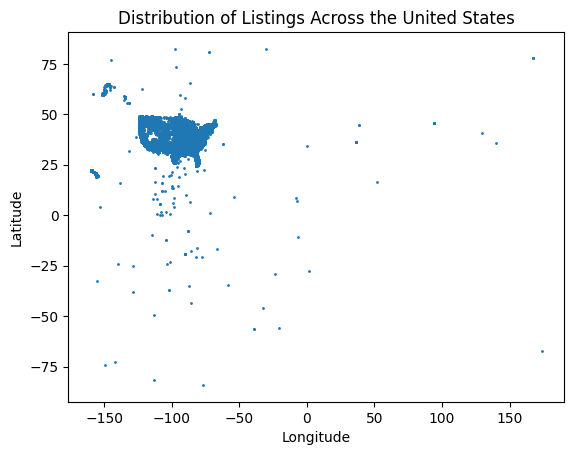

In [85]:
import matplotlib.pyplot as plt

# create a scatter plot of latitudes and longitudes
plt.scatter(df['long'], df['lat'], s=1)

# set axis labels and plot title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Distribution of Listings Across the United States')

# show the plot
plt.show()

In [96]:
df = df.dropna(subset=['lat', 'long'])  # remove rows with missing lat/long
df = df.sample(n=1000, random_state=42)

# Create a map centered on the US
us_map = folium.Map(location=[39.8283, -98.5795], zoom_start=4)

# Create a feature group to hold the markers
marker_group = folium.FeatureGroup(name='Listings')

# Add a marker for each listing
for index, row in df.iterrows():
    # Create a popup with some information about the listing
    popup_text = f"Model: {row['model']}<br>Price: {row['price']}"
    
    # Add the marker to the marker group
    folium.Marker(location=[row['lat'], row['long']], popup=popup_text).add_to(marker_group)

# Add the marker group to the map
marker_group.add_to(us_map)

# Add a layer control to the map
folium.LayerControl().add_to(us_map)
#resetting df
df = pd.read_csv('vehicles.csv')
# Show the map
us_map